In [1]:
from keras.utils import to_categorical
from keras.preprocessing.image import load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, AveragePooling2D, BatchNormalization, Activation
import os
import tensorflow as tf
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder

In [6]:
!unzip '/content/images.zip'

Streaming output truncated to the last 5000 lines.
  inflating: images/train/sad/30743.jpg  
  inflating: images/train/sad/30750.jpg  
  inflating: images/train/sad/30752.jpg  
  inflating: images/train/sad/30757.jpg  
  inflating: images/train/sad/30764.jpg  
  inflating: images/train/sad/30767.jpg  
  inflating: images/train/sad/30776.jpg  
  inflating: images/train/sad/3078.jpg  
  inflating: images/train/sad/30784.jpg  
  inflating: images/train/sad/30785.jpg  
  inflating: images/train/sad/30791.jpg  
  inflating: images/train/sad/30800.jpg  
  inflating: images/train/sad/30810.jpg  
  inflating: images/train/sad/30816.jpg  
  inflating: images/train/sad/3082.jpg  
  inflating: images/train/sad/30833.jpg  
  inflating: images/train/sad/30838.jpg  
  inflating: images/train/sad/30839.jpg  
  inflating: images/train/sad/30846.jpg  
  inflating: images/train/sad/30863.jpg  
  inflating: images/train/sad/30879.jpg  
  inflating: images/train/sad/30880.jpg  
  inflating: images/train/s

In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
TRAIN_DIR = '/content/images/train'
TEST_DIR = '/content/images/test'

In [4]:
def createdataframe(dir):
    image_paths = []
    labels = {'angry':[],'disgust':[],'fear':[],'happy':[],'neutral':[],'sad':[],'surprise':[]}
    for label in os.listdir(dir):
        for imagename in os.listdir(os.path.join(dir,label)):
            image_paths.append(os.path.join(dir,label,imagename))
            for i in labels.keys():
              if i == label:
                labels[i].append(1)
              else:
                labels[i].append(0)
        print(label, "completed")
    return [image_paths,labels['angry'],labels['disgust'],labels['fear'],labels['happy'],labels['neutral'],labels['sad'],labels['surprise']]


In [7]:
train = pd.DataFrame()
train['image'], train['angry'], train['disgust'], train['fear'], train['happy'], train['neutral'], train['sad'], train['surprise'] = createdataframe(TRAIN_DIR)

angry completed
disgust completed
neutral completed
fear completed
sad completed
surprise completed
happy completed


In [8]:
print(train.head())

                                   image  angry  disgust  fear  happy  \
0  /content/images/train/angry/15988.jpg      1        0     0      0   
1  /content/images/train/angry/34360.jpg      1        0     0      0   
2  /content/images/train/angry/13415.jpg      1        0     0      0   
3   /content/images/train/angry/3716.jpg      1        0     0      0   
4   /content/images/train/angry/5598.jpg      1        0     0      0   

   neutral  sad  surprise  
0        0    0         0  
1        0    0         0  
2        0    0         0  
3        0    0         0  
4        0    0         0  


In [9]:
test = pd.DataFrame()
test['image'], test['angry'], test['disgust'], test['fear'], test['happy'], test['neutral'], test['sad'], test['surprise'] = createdataframe(TEST_DIR)

angry completed
disgust completed
neutral completed
fear completed
sad completed
surprise completed
happy completed


In [10]:
print(test.head())

                                  image  angry  disgust  fear  happy  neutral  \
0  /content/images/test/angry/21068.jpg      1        0     0      0        0   
1  /content/images/test/angry/28560.jpg      1        0     0      0        0   
2   /content/images/test/angry/5400.jpg      1        0     0      0        0   
3  /content/images/test/angry/15835.jpg      1        0     0      0        0   
4  /content/images/test/angry/15654.jpg      1        0     0      0        0   

   sad  surprise  
0    0         0  
1    0         0  
2    0         0  
3    0         0  
4    0         0  


In [5]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image,color_mode='grayscale',target_size=(48,48))
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features),48,48,1)
    return features

In [11]:
train_features = extract_features(train['image'])

  0%|          | 0/28821 [00:00<?, ?it/s]

In [12]:
test_features = extract_features(test['image'])

  0%|          | 0/7066 [00:00<?, ?it/s]

In [13]:
x_train = train_features/255.0
x_test = test_features/255.0

In [14]:
le = LabelEncoder()
y_train = train[['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']].apply(le.fit_transform)
y_test = test[['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']].apply(le.fit_transform)

In [15]:
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of y_train: (28821, 7)
Shape of y_test: (7066, 7)


In [16]:
print(y_train.head(1))

   angry  disgust  fear  happy  neutral  sad  surprise
0      1        0     0      0        0    0         0


In [ ]:
# y_train = le.transform(train[['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']])
# y_test = le.transform(test[['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']])

In [ ]:
# y_train = to_categorical(y_train,num_classes = 7)
# y_test = to_categorical(y_test,num_classes = 7)

In [17]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(7, 7), padding='same', input_shape=(48,48,1)))
model.add(BatchNormalization())

model.add(Conv2D(filters=32, kernel_size=(7, 7), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.5))

model.add(Conv2D(filters=64, kernel_size=(5, 5), padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(filters=64, kernel_size=(5, 5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.5))

model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.5))

model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.5))

model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(7, activation='softmax'))

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        1600      
                                                                 
 batch_normalization (Batch  (None, 48, 48, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        50208     
                                                                 
 batch_normalization_1 (Bat  (None, 48, 48, 32)        128       
 chNormalization)                                                
                                                                 
 activation (Activation)     (None, 48, 48, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 32)        0

In [18]:
with tf.device('/device:GPU:0'):
  model.fit(x= x_train,y = y_train, batch_size = 128, epochs = 128, validation_data = (x_test,y_test))

Epoch 1/128
226/226 [==============================] - 36s 91ms/step - loss: 1.8960 - accuracy: 0.2251 - val_loss: 1.8226 - val_accuracy: 0.2583
Epoch 2/128
226/226 [==============================] - 17s 76ms/step - loss: 1.8118 - accuracy: 0.2466 - val_loss: 1.8207 - val_accuracy: 0.2583
Epoch 3/128
226/226 [==============================] - 17s 77ms/step - loss: 1.7827 - accuracy: 0.2614 - val_loss: 2.0815 - val_accuracy: 0.1342
Epoch 4/128
226/226 [==============================] - 17s 77ms/step - loss: 1.6952 - accuracy: 0.3070 - val_loss: 1.6554 - val_accuracy: 0.3218
Epoch 5/128
226/226 [==============================] - 17s 76ms/step - loss: 1.6267 - accuracy: 0.3470 - val_loss: 1.7381 - val_accuracy: 0.3098
Epoch 6/128
226/226 [==============================] - 17s 75ms/step - loss: 1.5700 - accuracy: 0.3747 - val_loss: 1.5127 - val_accuracy: 0.3865
Epoch 7/128
226/226 [==============================] - 17s 77ms/step - loss: 1.5332 - accuracy: 0.3884 - val_loss: 1.6259 - val_ac

In [19]:
model_json = model.to_json()
with open("emotiondetector.json",'w') as json_file:
    json_file.write(model_json)
model.save("emotiondetector.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [20]:
label = ['angry','disgust','fear','happy','neutral','sad','surprise']

In [21]:
def ef(image):
    img = load_img(image,grayscale =  True )
    feature = np.array(img)
    feature = feature.reshape(1,48,48,1)
    return feature/255.0


In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

original image is of sad


/usr/local/lib/python3.10/dist-packages/keras/src/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


1/1 [==============================] - 1s 792ms/step
model prediction is  neutral
[[0.09794245 0.00098136 0.06377047 0.04842517 0.6610793  0.11983601
  0.00796534]]


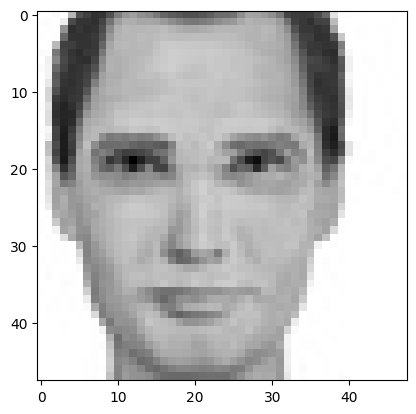

In [23]:
image = 'images/test/sad/10171.jpg'
print("original image is of sad")
img = ef(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is ",pred_label)
print(pred)
plt.imshow(img.reshape(48,48),cmap='gray')

original image is of fear
1/1 [==============================] - 0s 20ms/step
[[0.00805158 0.00056159 0.5260823  0.00278683 0.01011924 0.02696295
  0.42543548]]
model prediction is  fear


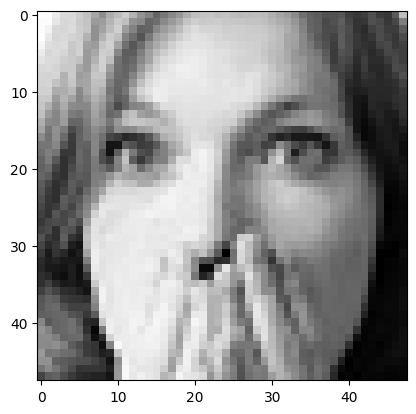

In [24]:
image = 'images/train/fear/16273.jpg'
print("original image is of fear")
img = ef(image)
pred = model.predict(img)
print(pred)
pred_label = label[pred.argmax()]
print("model prediction is ",pred_label)
plt.imshow(img.reshape(48,48),cmap='gray')

original image is of disgust
1/1 [==============================] - 0s 19ms/step
model prediction is  fear


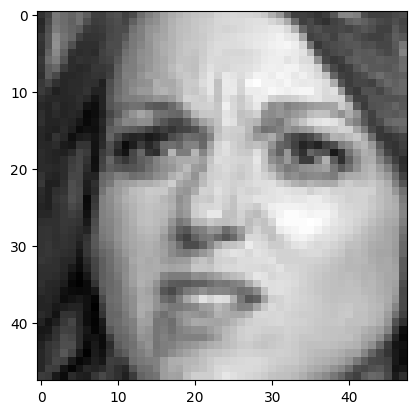

In [25]:
image = 'images/test/disgust/10532.jpg'
print("original image is of disgust")
img = ef(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is ",pred_label)
plt.imshow(img.reshape(48,48),cmap='gray')

original image is of happy
1/1 [==============================] - 0s 19ms/step
model prediction is  surprise


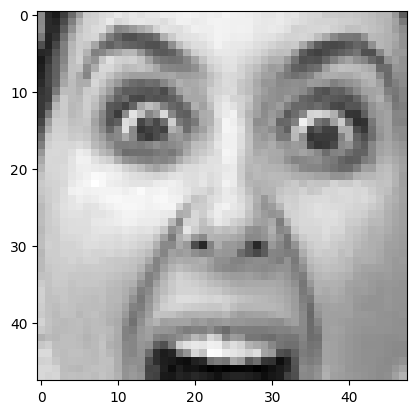

In [26]:
image = 'images/test/happy/10141.jpg'
print("original image is of happy")
img = ef(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is ",pred_label)
plt.imshow(img.reshape(48,48),cmap='gray')

original image is of surprise
1/1 [==============================] - 0s 20ms/step
model prediction is  surprise


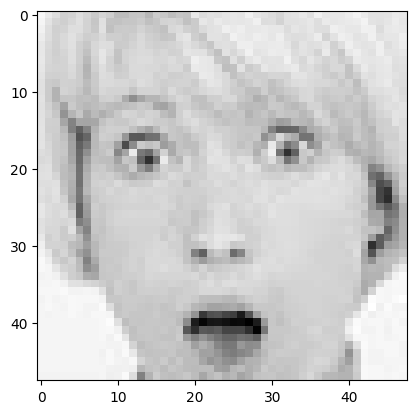

In [27]:
image = 'images/test/surprise/10185.jpg'
print("original image is of surprise")
img = ef(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is ",pred_label)
plt.imshow(img.reshape(48,48),cmap='gray')

original image is of angry
1/1 [==============================] - 0s 18ms/step
model prediction is  angry


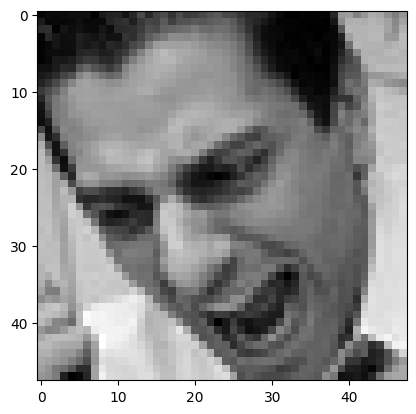

In [28]:
image = 'images/test/angry/10163.jpg'
print("original image is of angry")
img = ef(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is ",pred_label)
plt.imshow(img.reshape(48,48),cmap='gray')
